# Лабораторная 1

**Цель**: изучить метод обратного распространения ошибки для обучения глубоких нейронных сетей на примере двухслойной полносвязной нейронной сети   
**Скрытый слой:** 1

## Задачи

1. Изучить общие схемы работы метода обратного распространения ошибки с помощью стохастического градиентного спуска
2. Вывести мат-формулы:
    - для вычисления градиентов функции ошибки по параметрам нейронной сети
    - формулы коррекции весов.
3. Реализация и тестирование метода обратного распространения ошибки для классификации рукописных цифр из набора данных MNIST
   - Загрузить и проверить данные: демонстрацию избранных изображений и меток классов для подтверждения корректности загрузки и совпадения размерности
   - По окончании каждой эпохи в процессе обучения модели вывести ошибку классификации на тренировочном наборе данных и время выполнения эпохи.
   - После обучения вывести ошибку классификации на тестовом наборе данных.

## Конфигурация нейронной сети:

**Число нейронов входного слоя:** w x h (28 x 28)  
**Число нейронов вых слоя:** k = 10 (числов классов)  
**Число нейронов скрытого слоя:** s

**Параметры обучения:** 
- cкорость обучения (learning rate)
- размер пачки данных (batch size)
- количество эпох являются параметрами метода обучения

**Ф. активации скрытого слоя:** ReLU  
**Ф. активации вых слоя:** softmax  
**Ф. активации вх слоя:** нет

**Ф ош.:** кросс-энтропия

## Набор параметров для демонстрации: 

- **Размер пачки:** от 8 до 64 изображений  
- **Скорость обучения:** 0.1  
- **Количество скрытых нейронов s:** 300  
- **Количество эпох:** 20

## ❗❗❗ Решение

### Подключение библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy
import os       
import time

from timeit import default_timer as timer

## ✅ Считывание MNIST 
**x:** изображения  
**y:** метки (значения 0, ..., 9)

In [2]:
def get_train_test_data():
    path = 'E:/MNIST/'
    
    if not os.path.exists(path + 'train-images-idx3-ubyte'):
        raise FileNotFoundError(f"Файл {path + 'train-images-idx3-ubyte'} не найден.") 
    if not os.path.exists(path + 't10k-images-idx3-ubyte'):
        raise FileNotFoundError(f"Файл {path + 't10k-images-idx3-ubyte'} не найден.") 
    if not os.path.exists(path + 'train-labels-idx1-ubyte'):
        raise FileNotFoundError(f"Файл {path + 'train-labels-idx1-ubyte'} не найден.") 
    if not os.path.exists(path + 't10k-labels-idx1-ubyte'):
        raise FileNotFoundError(f"Файл {path + 't10k-labels-idx1-ubyte'} не найден.") 
    
    x_train = idx2numpy.convert_from_file(path + 'train-images-idx3-ubyte')
    x_test = idx2numpy.convert_from_file(path + 't10k-images-idx3-ubyte')
    
    y_train = idx2numpy.convert_from_file(path + 'train-labels-idx1-ubyte')
    y_test = idx2numpy.convert_from_file(path + 't10k-labels-idx1-ubyte')

    return x_train, x_test, y_train, y_test

In [3]:
x_train, x_test, y_train, y_test = get_train_test_data()

## ✅ Проверка корректности считывания

In [4]:
def plot_mnist_samples(images, labels, num_samples = 10):
    # Выбирает случайные примеры
    # len(images): Это количество элементов, из которых будет производиться выбор
    # size=num_samples: Определяет, сколько элементов будет выбрано
    # replace=False: один и тот же индекс не может быть выбран несколько раз
    indices = np.random.choice(len(images), size = num_samples, replace = False)
    images_to_plot = images[indices]
    labels_to_plot = labels[indices]

    # Создает фигуру и подписи
    fig, axes = plt.subplots(1, num_samples, figsize = (15, 3))
    fig.suptitle('Примеры из MNIST')

    # Отображает изображения
    for i, ax in enumerate(axes):
        ax.imshow(images_to_plot[i], cmap = 'gray')
        ax.set_title(f'Метка: {labels_to_plot[i]}')
        # отключает отображение осей на графике. 
        ax.axis('off')

    # подбирает такие параметры размещения элементов, чтобы избежать наложений
    plt.tight_layout()
    plt.show()

**Размер обуч. и тестовой выборки:**

In [5]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [6]:
x_test.shape, y_test.shape

((10000, 28, 28), (10000,))

**Примеры:**

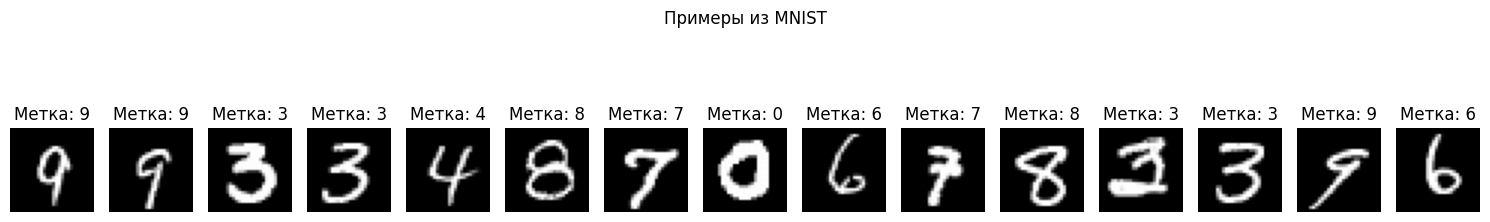

In [7]:
plot_mnist_samples(x_train, y_train, 15)

**Уникальные значения y_test:** (всего 10000 примеров)

In [8]:
# Подсчет уникальных значений и их количества
unique, counts = np.unique(y_test, return_counts=True)

# Вывод результатов
for value, count in zip(unique, counts):
    print(f"{value}: {count}")

0: 980
1: 1135
2: 1032
3: 1010
4: 982
5: 892
6: 958
7: 1028
8: 974
9: 1009


**Уникальные значения y_train:** (всего 60000 примеров)

In [9]:
# Подсчет уникальных значений и их количества
unique, counts = np.unique(y_train, return_counts=True)

# Вывод результатов
for value, count in zip(unique, counts):
    print(f"{value}: {count}")

0: 5923
1: 6742
2: 5958
3: 6131
4: 5842
5: 5421
6: 5918
7: 6265
8: 5851
9: 5949


## ✅ Преобразование данных

In [10]:
# количество образцов в обуч/ тест. выборке
size_train, size_test = x_train.shape[0], x_test.shape[0]

# 2D-изображение размером 28x28 -> массив длиной 784 (28 х 28).
# / 255: Нормализация значений пикселей
x_train = x_train.reshape(size_train, 28 * 28) / 255
x_test = x_test.reshape(size_test, 28 * 28) / 255

# создает единичную матрицу размером 10x10, где на главной диагонали находятся единицы, а остальные элементы — нули.
# Например, если в y_train есть значение 2, то np.eye(10)[2] вернет строку [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

 ## ✅ Функции активации 1-2, функция ошибки, точность (accuracy)

### Функция активации 1: ReLU  (+ ее производная)

In [11]:
def ReLU(x):
    return np.maximum(x, 0)

def d_ReLU_dx(x):
    return np.where(x > 0.0, 1, 0)

### Функция активации 2: Softmax

In [12]:
def softmax(u):
    shift = np.max(u, axis = u.ndim - 1, keepdims = True)
    u = np.exp(u - shift)
    denominator = np.sum(u, axis=u.ndim - 1, keepdims = True)

    return u / denominator

### Функция ошибки: кросс-энтропия

In [13]:
def crossEntropyLoss(y, u):
    return np.mean(-np.sum(y * np.log(u), axis = 1))

### Точность (accuracy)

In [14]:
def accuracy(y, u):
  return np.mean(np.argmax(y, axis = 1) == np.argmax(u, axis = 1))

 ## ✅Метод обратного распространения ошибки

### Класс нейронной сети (NeuralNetwork)

In [15]:
def dE_dW0(z0, err_u, x_transpose, w1_transpose):
    # (u - y) * w2 * φ(z0)
    err_v = np.matmul(err_u, w1_transpose) * d_ReLU_dx(z0)
    
    # x * {(u - y) * w2 * φ(z0)}
    dE_dW0 = np.matmul(x_transpose, err_v)

    return err_v, dE_dW0

In [16]:
def dE_dW1(u, y, v_transpose):
    # u_j - y_j: знач ошибки вых сл.
    err_u = (u - y) / u.shape[0]

    # (u_j - y_j) * v_s
    dE_dW1 = np.matmul(v_transpose, err_u)    
    
    return err_u, dE_dW1

In [17]:
class NeuralNetwork(object):
    # Конструктор
    def __init__(self, _inputLayerSize = 28 * 28, _s = 300, _k = 10, learning_rate = 0.1, batch_size = 32):
        self.input_layers_size = _inputLayerSize
        self.s = _s
        self.k = _k

        # первый слой вх -> скрытый: веса, смещения
        # стандартного нормального распределения (среднее = 0, стандартное отклонение = 1)
        self.w0 = np.random.randn(_inputLayerSize, _s) * np.sqrt(2.0 /_inputLayerSize)
        self.b0 = np.zeros((1, _s))
        
        # второй слой скрытый -> вых: веса, смещения
        # стандартного нормального распределения (среднее = 0, стандартное отклонение = 1)
        self.w1 = np.random.randn(_s, _k) * np.sqrt(2.0 /_s)
        self.b1 = np.zeros((1, _k))

        self.learning_rate = learning_rate
        self.batch_size = batch_size
    
    # прямой ход 
    def forward(self, x):
        self.z0 = np.matmul(x, self.w0) + self.b0
        self.v = ReLU(self.z0)

        self.z1 = np.matmul(self.v, self.w1) + self.b1
        self.u = softmax(self.z1)

    # обратных ход: вычисление градиента функции ошибки + корректировка весов сети при помощи посчитанных градиентов
    def backward(self, x, y, learningRate):
        err_u, dEdW1 = dE_dW1(self.u, y, self.v.T)
        err_v, dEdW0 = dE_dW0(self.z0, err_u, x.T, self.w1.T)

        # сумма по каждому столбцу элементов массива err_v
        delta_b0 = np.sum(err_v, axis = 0, keepdims = True)
        # сумма по каждому столбцу элементов массива err_u
        delta_b1 = np.sum(err_u, axis = 0, keepdims = True)

        # Корректировка
        # λ = learning_rate
        self.w0 -= self.learning_rate * dEdW0
        self.w1 -= self.learning_rate * dEdW1

        self.b0 -= self.learning_rate * delta_b0
        self.b1 -= self.learning_rate * delta_b1

    def train_one_epoch(self, x_train, y_train):
        i = 0
        # Цикл, пока не обработаны все данные для обучения
        while i < len(x_train):
            # Извлечение текущего подмассива (batch) данных для обучения + соответствующих меток для текущей партии данных
            #  Срез массива x_train[i:i + self.batch_size]: создает новый массив, содержащий элементы x_train от индекса i до i + self.batch_size - 1.
            x_train_batch = x_train[i:i + self.batch_size]
            y_train_batch = y_train[i:i + self.batch_size]

            # Прямой проход (forward propagation) + Обратный проход (backward propagation)
            self.forward(x_train_batch)
            self.backward(x_train_batch, y_train_batch, self.learning_rate)

            i += self.batch_size

        # predictions
        self.forward(x_train)

        # Вычисление значения функции потерь и точности
        value_crossEntropy = crossEntropyLoss(y_train, self.u)
        value_accuracy = accuracy(y_train, self.u)

        return value_crossEntropy, value_accuracy

    # обучение нейронной сети
    def train(self, X_train, y_train, num_epochs = 10):
        print('Training has started: ...')
        print('______________________________________________________________________________')        
        
        all_time = time.time()
        for epoch in range(num_epochs):
            epoch_time_start = time.time()
            
            crossEntropyValue, accuracyValue = self.train_one_epoch(x_train, y_train)
            
            epoch_time = time.time()
            duration_time = epoch_time - epoch_time_start
            print('Epoch: {}; Время работы: {:.3f} sec; Ошибка: {:.6f}; Точность: {:.6f}'.format(epoch, duration_time, crossEntropyValue, accuracyValue))
            
        print(f"Итоговое время обучения: {(time.time() - all_time):.3f} sec")

    # тестирование нейронной сети + вывод value_crossEntropy и accuracy
    def test(self, x_test, y_test):
        print('Testing has started: ...')
        print('______________________________________________________________________________')
        all_time = time.time()
        
        self.forward(x_test)
        
        value_crossEntropy = crossEntropyLoss(y_test, self.u)
        value_accuracy = accuracy(y_test, self.u)

        duaration_time = time.time() - all_time
        
        print('Время работы: {} sec; Ошибка = {:6f}; Точность = {:6f}'.format(duaration_time, value_crossEntropy, value_accuracy))

### Набор параметров для демонстрации:

- **Размер пачки:** от 8 до 64 изображений  
- **Скорость обучения:** 0.1  
- **Количество скрытых нейронов s:** 300  
- **Количество эпох:** 20

In [18]:
input_layer_size = 28 * 28  
s = 300  
k = 10  

learning_rate = 0.1
epochs = 20
batch_size = 32

### Создание объекта класса NeuralNetwork

In [19]:
nn = NeuralNetwork(input_layer_size, s, k, learning_rate)

### Обучение модели

In [20]:
nn.train(x_train, y_train, epochs)

Training has started: ...
______________________________________________________________________________
Epoch: 0; Время работы: 3.655 sec; Ошибка: 0.166133; Точность: 0.950650
Epoch: 1; Время работы: 3.815 sec; Ошибка: 0.107266; Точность: 0.968217
Epoch: 2; Время работы: 4.161 sec; Ошибка: 0.078438; Точность: 0.977217
Epoch: 3; Время работы: 4.125 sec; Ошибка: 0.061905; Точность: 0.981833
Epoch: 4; Время работы: 3.548 sec; Ошибка: 0.050820; Точность: 0.985167
Epoch: 5; Время работы: 3.649 sec; Ошибка: 0.043072; Точность: 0.987767
Epoch: 6; Время работы: 3.458 sec; Ошибка: 0.037011; Точность: 0.989650
Epoch: 7; Время работы: 3.463 sec; Ошибка: 0.032175; Точность: 0.990967
Epoch: 8; Время работы: 3.884 sec; Ошибка: 0.027757; Точность: 0.992083
Epoch: 9; Время работы: 3.772 sec; Ошибка: 0.023963; Точность: 0.993617
Epoch: 10; Время работы: 3.506 sec; Ошибка: 0.021006; Точность: 0.994450
Epoch: 11; Время работы: 3.551 sec; Ошибка: 0.018683; Точность: 0.995217
Epoch: 12; Время работы: 3.44

### Тестирование модели

In [21]:
nn.test(x_test, y_test)

Testing has started: ...
______________________________________________________________________________
Время работы: 0.08929944038391113 sec; Ошибка = 0.067971; Точность = 0.980200
